In [1]:
# import packages
import numpy as np
import math as math
import pandas as pd
from astropy import units as u
import astropy.constants as const

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from scipy.interpolate import interp1d

%matplotlib inline

In [2]:
def get_params(filename):
    """Get orbit params from csv header"""
    header = np.array([])
    file = open(filename, 'r')
    for line in file:
        if line.startswith("#"):
            line.split(",")
            header = np.append(header,line.split(","))
    P = float(header[5].split(" ")[-2])
    dur = float(header[6].split(" ")[-2])
    return P, dur

In [3]:
# def calculate_residual(sim, obs, refsim):
#     """
#     Calculate residual between simulated and observed data.
#     Interpolates simulated data to match observed data timestamps.
    
#     Inputs
#         sim, obs: DataFrames with time, rv, theta of simulated, observed
#         refsim: Dataframe with simulated rv we are using as a reference
#     Returns
#         t_obs, residual: array of times for observations, and residuals
        
#     NB: t_obs is shortened by 10 indices at the end to avoid going out of
#       range of the interpolated observed data
      
#     """
    
#     t_sim = np.array(refsim['# time [d]'])
#     end = len(obs)//50
#     t_obs = np.array(obs['# time [d]'])[end:-end] # d -> hrs
    
#     #simrv = sim['radial velocity [m/s]'].to_numpy()
#     refsimrv = refsim['radial velocity [m/s]'].to_numpy()
#     obsrv = obs['radial velocity [m/s]'].to_numpy()[end:-end]

#     # interpolate the ref simulated data onto the synthetic observed time steps
#     f_interp = interp1d(t_sim, refsimrv,kind='cubic')
#     simobsrv = f_interp(t_obs)
#     # calculate the (sim - obs) residual
#     residual = simobsrv - obsrv
    
#     return t_obs*24, residual


In [41]:
## set error parameters (from MAROON-X, Jenn Burt)
sigma_phot = 1.7   # RV photon uncertainty [m/s]
sigma_floor = 0.5  # RV instrument floor [m/s]
sigma_jit = 0.5    # Stellar jitter term [m/s]
sigma_all = np.sqrt(sigma_phot**2 + sigma_floor**2 + sigma_jit**2) # Add all unc. terms in quadrature


In [45]:
koi = 961.01


file_asim = "rv_lcs/KOI_961.01_sim_rmrv_lc_b_0.0_phi_0.0278pi.csv"
P, dur = get_params(file_asim)
P *= 24   # convert to hours

# case A is the prediction which reflects physical reality
case_0_sim = pd.read_csv('rv_lcs/KOI_961.01_simmatch_rmrv_lc_b_0.0_phi_0.0pi.csv',
                    header=4)
case_0_obs = pd.read_csv('rv_lcs/KOI_961.01_synthobsmatch_rmrv_lc_b_0.0_phi_0.0pi.csv',
                    header=4)

# case B is the test case prediction
case_20_sim = pd.read_csv('rv_lcs/KOI_961.01_simmatch_rmrv_lc_b_0.0_phi_0.111pi.csv',
                         header=4)
case_20_obs = pd.read_csv('rv_lcs/KOI_961.01_synthobsmatch_rmrv_lc_b_0.0_phi_0.111pi.csv',
                         header=4)

# best obliquity model - best obliquity obs
t_0 = case_0_obs['# time [d]']*24
res_0 = case_0_sim['radial velocity [m/s]'] - case_0_obs['radial velocity [m/s]']

t_20 = case_20_obs['# time [d]']*24
res_20 = case_0_sim['radial velocity [m/s]'] - case_20_obs['radial velocity [m/s]']


saving plots/KOI_961.01_residuals.svg


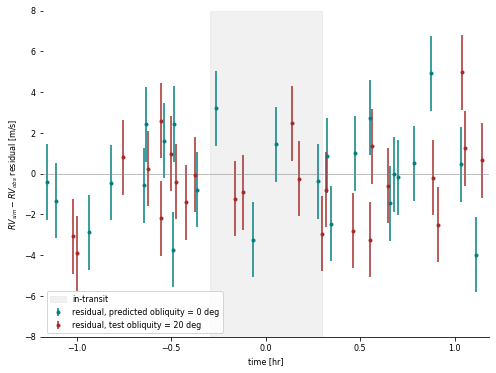

In [47]:
### Plot residuals ###

# figure setup
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
fs = 14 # font size
plt.rc('font', size=fs)


ax.errorbar(t_0 - P, res_0, yerr=sigma_all,
            c='teal', fmt='.',label=f"residual, predicted obliquity = 0 deg"
           )
ax.errorbar(t_20 - P, res_20, yerr=sigma_all,
            c='brown', fmt='.',label=f"residual, test obliquity = 20 deg"
           )


# formatting
ax.set_xlabel(r"time [hr]")
ax.set_ylabel(r"$RV_{sim} - RV_{obs}$ residual [m/s]")


window = np.array([-1,1])*2*dur
ax.set_xlim(window[0], window[1])
ax.set_ylim(-8,8)

# # additional visual markers
# ax.vlines(0.5*(dur)*np.array([-1,1]),ax.get_ylim()[0],ax.get_ylim()[1],
#           color='grey', alpha=0.4 , label=f"dur = {dur:.3}")

corner = (-dur*0.5, ax.get_ylim()[0])
width = dur  # hrs
height = np.diff(ax.get_ylim())[0]
ax.add_patch(Rectangle(corner, width, height,
                      color='lightgrey', alpha=0.3, zorder=1,
                      label="in-transit"))
ax.hlines(0,window[0],window[1],lw=1,colors='grey',alpha=0.5)

for spine in ax.spines: ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_visible(True)

# plt.text(ax.get_xlim()[0]*0.5, ax.get_ylim()[1]*0.75, f"stellar obliquity = {phi_star * (180/np.pi):.3} deg")

#ax.set_facecolor("lightgrey")
#plt.grid(c='white')
plt.rc('font', size=8)
plt.legend(loc='lower left')

filename=f"plots/KOI_{koi}_residuals.svg"
plt.savefig(filename, bbox_inches='tight',transparent=True)
print(f"saving {filename}")

In [39]:
koi = 254.01

# case A is the prediction which reflects physical reality
case_20_sim = pd.read_csv('rv_lcs/KOI_254.01_simmatch_rmrv_lc_b_0.0_phi_0.111pi.csv',
                          header=4)
case_20_obs = pd.read_csv('rv_lcs/KOI_254.01_synthobsmatch_rmrv_lc_b_0.0_phi_0.111pi.csv',
                    header=4)

# case B is the test case prediction
case_0_sim = pd.read_csv('rv_lcs/KOI_254.01_simmatch_rmrv_lc_b_0.0_phi_0.0pi.csv',
                    header=4)
case_0_obs = pd.read_csv('rv_lcs/KOI_254.01_synthobsmatch_rmrv_lc_b_0.0_phi_0.0pi.csv',
                    header=4)


file_asim = "rv_lcs/KOI_254.01_sim_rmrv_lc_b_0.0_phi_0.0pi.csv"
P, dur = get_params(file_asim)
P *= 24   # convert to hours

# best obliquity model - best obliquity obs
t_20 = case_20_obs['# time [d]']*24
res_20 = case_20_obs['radial velocity [m/s]'] - case_20_sim['radial velocity [m/s]']

# best obliquity model - test obliquity obs
t_0 = case_0_obs['# time [d]']*24
res_0 = case_20_sim['radial velocity [m/s]'] - case_0_obs['radial velocity [m/s]']

# t_20, res_20 = calculate_residual(case_20_sim, case_20_obs, case_20_sim)
# t_0, res_0 = calculate_residual(case_0_sim, case_0_obs, case_20_sim)

(58.0, 60.0)

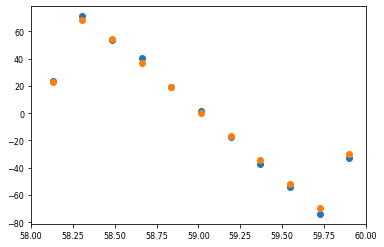

In [40]:
# compare the actual values we're subtracting 
plt.scatter(t_0, case_0_obs['radial velocity [m/s]'])
plt.scatter(t_0, case_20_sim['radial velocity [m/s]'])
plt.xlim(58,60)

saving plots/KOI_254.01_residuals.svg


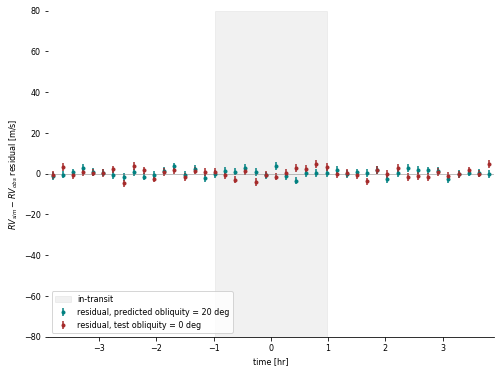

In [43]:
### Plot residuals ###

# figure setup
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
fs = 14 # font size
plt.rc('font', size=fs)


ax.errorbar(t_20 - P, res_20, yerr=sigma_all,
            c='teal', fmt='.',label=f"residual, predicted obliquity = 20 deg"
           )
ax.errorbar(t_0 - P, res_0, yerr=sigma_all,
            c='brown', fmt='.',label=f"residual, test obliquity = 0 deg"
           )


# formatting
ax.set_xlabel(r"time [hr]")
ax.set_ylabel(r"$RV_{sim} - RV_{obs}$ residual [m/s]")


window = np.array([-1,1])*2*dur
ax.set_xlim(window[0], window[1])
ax.set_ylim(-80,80)

# # additional visual markers
# ax.vlines(0.5*(dur)*np.array([-1,1]),ax.get_ylim()[0],ax.get_ylim()[1],
#           color='grey', alpha=0.4 , label=f"dur = {dur:.3}")

corner = (-dur*0.5, ax.get_ylim()[0])
width = dur  # hrs
height = np.diff(ax.get_ylim())[0]
ax.add_patch(Rectangle(corner, width, height,
                      color='lightgrey', alpha=0.3, zorder=1,
                      label="in-transit"))
ax.hlines(0,window[0],window[1],lw=1,colors='grey',alpha=0.5)

for spine in ax.spines: ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_visible(True)

# plt.text(ax.get_xlim()[0]*0.5, ax.get_ylim()[1]*0.75, f"stellar obliquity = {phi_star * (180/np.pi):.3} deg")

#ax.set_facecolor("lightgrey")
#plt.grid(c='white')
plt.rc('font', size=8)
plt.legend(loc='lower left')

filename=f"plots/KOI_{koi}_residuals.svg"
plt.savefig(filename, bbox_inches='tight',transparent=True)
print(f"saving {filename}")

In [10]:
dur

1.94884